In [2]:
import time
import subprocess

from PIL import Image
from PIL import ImageDraw
import numpy as np
import matplotlib.pyplot as plt

from pycoral.adapters import common
from pycoral.adapters import detect
from pycoral.utils.dataset import read_label_file
from pycoral.utils.edgetpu import make_interpreter


In [7]:
cls_model_path = (
    "experiments/co_compile_obj_cls/model/baseline/efficientnet-M_edgetpu.tflite"
)
cls_model2_path = "experiments/co_compile_obj_cls/model/baseline/inception_v2_224_quant_edgetpu.tflite"
det_model_path = (
    "experiments/co_compile_obj_cls/model/baseline/efficientdet-lite_edgetpu.tflite"
)

In [3]:
image = Image.open("experiments/co_compile_obj_cls/test_image.JPEG")
labels = read_label_file("data/object_detection/labels.txt")


In [4]:
cls_intp = make_interpreter(cls_model_path)
cls_intp.allocate_tensors()
cls2_intp = make_interpreter(cls_model2_path)
cls2_intp.allocate_tensors()
det_intp = make_interpreter(det_model_path)
det_intp.allocate_tensors()

In [12]:
cls_durs = []
for _ in range(100):
    st = time.perf_counter()
    cls_intp.invoke()
    dur = (time.perf_counter() - st) * 1000
    cls_durs.append(dur)

print(np.mean(cls_durs), np.std(cls_durs))


15.955004900042695 0.7445202857184285


In [5]:
cls_durs = []
for _ in range(100):
    st = time.perf_counter()
    cls2_intp.invoke()
    dur = (time.perf_counter() - st) * 1000
    cls_durs.append(dur)

print(np.mean(cls_durs), np.std(cls_durs))


68.22361810987786 2.1449504541036704


In [6]:
det_durs = []
for _ in range(100):
    st = time.perf_counter()
    det_intp.invoke()
    dur = (time.perf_counter() - st) * 1000
    det_durs.append(dur)

print(np.mean(det_durs), np.std(det_durs))


52.4989718200959 4.552529071022282


In [8]:
det_intp = make_interpreter(det_model_path)
det_intp.allocate_tensors()


_, scale = common.set_resized_input(
    det_intp, image.size, lambda size: image.resize(size, Image.ANTIALIAS)
)

In [9]:
for _ in range(5):
    start = time.perf_counter()
    det_intp.invoke()
    inference_time = time.perf_counter() - start
    objs = detect.get_objects(det_intp, 0.5, scale)
    print("%.2f ms" % (inference_time * 1000))

27.67 ms
30.68 ms
30.61 ms
30.82 ms
30.75 ms


In [ ]:
for obj in objs:
    print(labels.get(obj.id, obj.id))
    print("  id:    ", obj.id)
    print("  score: ", obj.score)
    print("  bbox:  ", obj.bbox)

person 1
  id:     0
  score:  0.87890625
  bbox:   BBox(xmin=86, ymin=106, xmax=113, ymax=148)


In [10]:
def draw_objects(draw, objs, labels):
    """Draws the bounding box and label for each object."""
    for obj in objs:
        bbox = obj.bbox
        draw.rectangle([(bbox.xmin, bbox.ymin), (bbox.xmax, bbox.ymax)], outline="red")
        draw.text(
            (bbox.xmin + 10, bbox.ymin + 10),
            "%s\n%.2f" % (labels.get(obj.id, obj.id), obj.score),
            fill="red",
        )

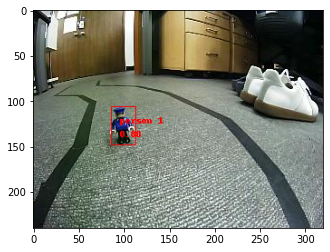

In [11]:
image = image.convert("RGB")
draw_objects(ImageDraw.Draw(image), objs, labels)
plt.imshow(image)